In [1]:
%matplotlib notebook

import PyLidar3
import numpy as np
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import threading
import time
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


In [2]:
def timed(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Elapsed time for {func.__name__}: {end - start:.6f} seconds")
        return result
    return wrapper

In [3]:
def init_kalman_filter():
    kf = KalmanFilter(dim_x=6, dim_z=3)
    
    kf.F = np.array([[1, 0, 0, 1, 0, 0],
                     [0, 1, 0, 0, 1, 0],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 1]])
    
    kf.H = np.array([[1, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0]])
    
    kf.R *= 10  # Measurement noise
    q = Q_discrete_white_noise(dim=3, dt=1, var=0.1)
    kf.Q[0:3, 0:3] = q
    kf.Q[3:6, 3:6] = q
    
    kf.P *= 100  # Initial uncertainty
    
    return kf


In [4]:
def get_clusters(clusterOp_data):
    cluster_n = []  # initialize empty list for first cluster
    clusters = []  # initialize list to hold all clusters

    for value in clusterOp_data:
        if value == 720:
            if cluster_n:  # check if cluster_n already has values
                clusters.append(cluster_n)  # if so, add it to clusters
                cluster_n = []  # reset cluster_n to empty list
        else:
            cluster_n.append(value)  # add value to current cluster

    if cluster_n:  # handle the last cluster after the loop ends
        clusters.append(cluster_n)

    return clusters

In [5]:
@timed
def collect_data():
    gen = Obj.StartScanning()
    data = next(gen)
    distance = []
    for points in data:
        distance.append(data[points])
    Obj.StopScanning()
    return distance

In [6]:
@timed
def process_data(distance):
    input_buffer = allocate(shape=(360,), dtype=np.int32)
    np.copyto(input_buffer, distance)
    output_buffer = allocate(shape=(380,), dtype=np.int32)

    dma.sendchannel.transfer(input_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.transfer(output_buffer)
    dma.recvchannel.wait()

    clusterOp_data = []
    for x in output_buffer:
        if x != 0 or output_buffer.tolist().count(x) == 1:
            clusterOp_data.append(x)

    del input_buffer, output_buffer

    clusters = get_clusters(clusterOp_data)
    return clusters

In [7]:
def find_centroids(clusters, distance):
    centroids = []
    
    for cluster in clusters:
        cluster_size = len(cluster)
        clusterTheta = np.array(cluster)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        
        centroid_distance = np.mean(clusterDistance)
        centroid_angle = np.mean(clusterTheta)
        
        centroids.append((centroid_angle, centroid_distance, cluster_size))
    
    return centroids

In [8]:
def update_plot(ax1, ax2, ax3, distance, clusters, centroids, master_list=[], prev_master_list=[]):
    ax1.clear()
    ax1.scatter(np.deg2rad(angle), distance, s=5)
    ax1.set_title("Raw Data")
    ax1.set_ylim(0, max(distance))

    ax2.clear()
    for cluster in clusters:
        clusterTheta = np.array(cluster)
        idx = np.isin(angle, clusterTheta)
        clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
        try:
            ax2.scatter(np.deg2rad(clusterTheta), clusterDistance, s=5)
        except Exception as e:
            print('\033[31m' +str(clusterTheta) + '\033[0m')

    # Plot centroids
    centroid_angles, centroid_distances, _ = zip(*centroids)
    ax2.scatter(np.deg2rad(centroid_angles), centroid_distances, s=50, marker='x', c='red', label='Centroids')

    ax2.set_title("Clustered Data")
    ax2.set_ylim(0, max(distance))
    ax2.legend()

    ax3.clear()
    color_idx = 0
    for master_cluster in prev_master_list:
        angle1 = master_cluster['Angle']
        distance1 = master_cluster['Distance']
        size = master_cluster['Size']
        cluster_id = master_cluster['ID']
        color = f'C{cluster_id % 10}'
        ax3.scatter(np.deg2rad(angle1), distance1, s=25, marker='d', c=color)
        color_idx += 1

    color_idx = 0
    for master_cluster in master_list:
        angle1 = master_cluster['Angle']
        distance1 = master_cluster['Distance']
        size = master_cluster['Size']
        cluster_id = master_cluster['ID']
        color = f'C{cluster_id % 10}'
        ax3.scatter(np.deg2rad(angle1), distance1, s=50, marker='x', c=color)
        color_idx += 1

    ax3.set_title("Master List")
    ax3.set_ylim(0, max(distance))


In [9]:
def match_clusters(curr_centroids, master_list, threshold_distance):
    matches = []
    curr_matched = []
    master_scores = []
    for i, master_cluster in enumerate(master_list):
        min_score = float('inf')
        matched_cluster = None
        for j, curr_cluster in enumerate(curr_centroids):
            if j in curr_matched:
                continue
                
            delta_angle = abs(curr_cluster[0] - master_cluster['Angle'])
            delta_distance = abs(curr_cluster[1] - master_cluster['Distance'])
            prev_distance = master_cluster['Distance']
            delta_size = abs(curr_cluster[2] - master_cluster['Size'])
            
            if delta_distance > threshold_distance:
                continue
            
            polar_euclidean_distance = np.sqrt(delta_distance ** 2 + prev_distance ** 2 - 2 * delta_distance * prev_distance * np.cos(delta_angle))
            score = delta_size * (delta_angle * 10) * delta_distance
            
            if score < min_score:
                min_score = score
                delta_polar_distance = polar_euclidean_distance
                matched_cluster = (j, curr_cluster, score)
        
        if matched_cluster:
            matches.append((i, *matched_cluster))
            curr_matched.append(matched_cluster[0])
            master_scores.append(matched_cluster[2])
        
    # Assign new ID to current clusters not matched to any cluster in the master list
    for j, curr_cluster in enumerate(curr_centroids):
        if j not in curr_matched:
            cluster_id = len(master_list)
            master_list.append({'ID': cluster_id, 'Angle': curr_cluster[0], 'Distance': curr_cluster[1], 'Size': curr_cluster[2]})
        
    # Remove excess clusters from master_list if there are more clusters in master_list than in curr_centroids
    if len(curr_centroids) < len(master_list):
        num_clusters_to_remove = len(master_list) - len(curr_centroids)
        for i in range(num_clusters_to_remove):
            max_score_index = np.argmax(master_scores)
            master_scores.pop(max_score_index)
            master_list.pop(max_score_index)
    
    # Update the matched clusters in master_list
    new_master_list = []
    for match in matches:
        prev_index, curr_index, curr_cluster, score = match
        cluster_id = master_list[prev_index]['ID']
        kf = master_list[prev_index]['KF']
    
        kf.predict()
        kf.update(np.array(curr_cluster))
    
        new_master_list.append({'ID': cluster_id, 'Angle': kf.x[0],'Distance': kf.x[1], 'Size': kf.x[2], 'KF': kf})
        
        print(f"Kalman Filter for cluster ID {cluster_id}:")
        print(kf)

    
    return new_master_list


In [10]:
angle = np.arange(0, 360)
port = "/dev/ttyUSB0"  # linux
Obj = PyLidar3.YdLidarX4(port, 12000)

if Obj.Connect():
    print(Obj.GetDeviceInfo())
else:
    print("Error connecting to device")
    exit(1)

ol = Overlay('/home/xilinx/pynq/overlays/clusterOp2/clusterOp2.bit')
ol.clusterOp2_0.register_map
CONTROL_REGISTER = 0x0
ol.clusterOp2_0.write(CONTROL_REGISTER, 0x81)  # 0x81 will set bit 0
dma = ol.axi_dma

{'model_number': '6', 'firmware_version': '1.5', 'hardware_version': '1', 'serial_number': '201904120'}


<IPython.core.display.Javascript object>


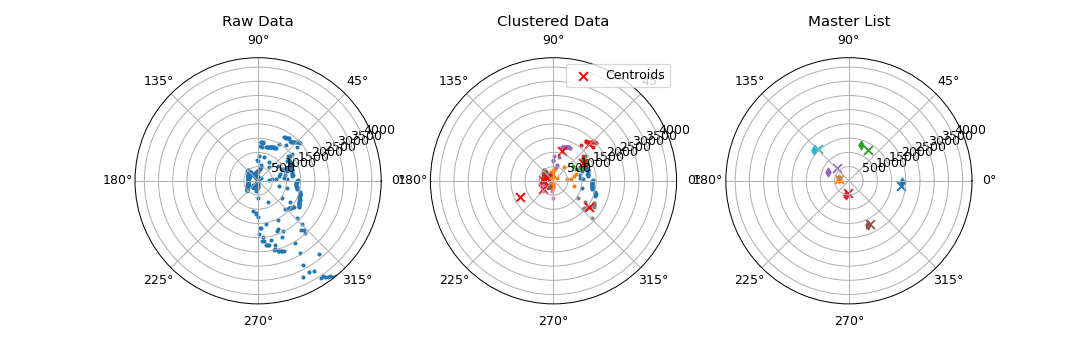

Iteration 1
Elapsed time for collect_data: 3.360854 seconds
Elapsed time for process_data: 0.108998 seconds
Elapsed time for iteration 1: 3.503404 seconds
Iteration 2
Elapsed time for collect_data: 3.357515 seconds
Elapsed time for process_data: 0.114076 seconds
Kalman Filter for cluster ID 0:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 321.01528624 1505.7648582    16.43152487   32.97213756   49.85141798    -4.31524868]].T
P = [[ 9.52386615e+00  1.13257338e-04  1.13257338e-04  4.76133848e+00
      -1.13257338e-03 -1.13257338e-03]
     [ 1.13257338e-04  9.52403604e+00  2.26514675e-04 -1.13257338e-03
       4.75963962e+00 -2.26514675e-03]
     [ 1.13257338e-04  2.26514675e-04  9.52403604e+00 -1.13257338e-03
      -2.26514675e-03  4.75963962e+00]
     [ 4.76133848e+00 -1.13257338e-03 -1.13257338e-03  5.24116152e+01
       6.13257338e-02  6.13257338e-02]
     [-1.13257338e-03  4.75963962e+00 -2.26514675e-03  6.13257338e-02
       5.25036038e+01  1.22651468e-01]
     [-1.132573

Kalman Filter for cluster ID 5:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[169.26434853 393.40421147  78.28619266  18.83799614 -26.51125051   27.13807342]].T
P = [[ 9.52386615e+00  1.13257338e-04  1.13257338e-04  4.76133848e+00
      -1.13257338e-03 -1.13257338e-03]
     [ 1.13257338e-04  9.52403604e+00  2.26514675e-04 -1.13257338e-03
       4.75963962e+00 -2.26514675e-03]
     [ 1.13257338e-04  2.26514675e-04  9.52403604e+00 -1.13257338e-03
      -2.26514675e-03  4.75963962e+00]
     [ 4.76133848e+00 -1.13257338e-03 -1.13257338e-03  5.24116152e+01
       6.13257338e-02  6.13257338e-02]
     [-1.13257338e-03  4.75963962e+00 -2.26514675e-03  6.13257338e-02
       5.25036038e+01  1.22651468e-01]
     [-1.13257338e-03 -2.26514675e-03  4.75963962e+00  6.13257338e-02
       1.22651468e-01  5.25036038e+01]]
x_prior = [[131.58333333 446.41666667  24.           0.           0.    0.        ]].T
P_prior = [[2.00025e+02 5.00000e-02 5.00000e-02 1.00000e+02 0.00000e+00 0.00000e+00]
  

Elapsed time for iteration 2: 4.875240 seconds
Iteration 3
Elapsed time for collect_data: 3.362863 seconds
Elapsed time for process_data: 0.091469 seconds
Kalman Filter for cluster ID 0:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 3.28561168e+02  1.57018551e+03  1.72800547e+01  1.26284831e+01   6.15015080e+01 -1.89525120e-01]].T
P = [[ 8.77274814e+00  1.63663796e-03  1.63663796e-03  7.01654166e+00
      -2.00440589e-03 -2.00440589e-03]
     [ 1.63663796e-03  8.77520310e+00  3.27327592e-03 -2.00440589e-03
       7.01353505e+00 -4.00881178e-03]
     [ 1.63663796e-03  3.27327592e-03  8.77520310e+00 -2.00440589e-03
      -4.00881178e-03  7.01353505e+00]
     [ 7.01654166e+00 -2.00440589e-03 -2.00440589e-03  1.23209982e+01
       8.05929606e-02  8.05929606e-02]
     [-2.00440589e-03  7.01353505e+00 -4.00881178e-03  8.05929606e-02
       1.24418877e+01  1.61185921e-01]
     [-2.00440589e-03 -4.00881178e-03  7.01353505e+00  8.05929606e-02
       1.61185921e-01  1.24418877e+01]]
x

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[137.24872746 346.16092687  35.7106553  -21.80116195 -43.00940642  -28.54534384]].T
P = [[ 8.77274814e+00  1.63663796e-03  1.63663796e-03  7.01654166e+00
      -2.00440589e-03 -2.00440589e-03]
     [ 1.63663796e-03  8.77520310e+00  3.27327592e-03 -2.00440589e-03
       7.01353505e+00 -4.00881178e-03]
     [ 1.63663796e-03  3.27327592e-03  8.77520310e+00 -2.00440589e-03
      -4.00881178e-03  7.01353505e+00]
     [ 7.01654166e+00 -2.00440589e-03 -2.00440589e-03  1.23209982e+01
       8.05929606e-02  8.05929606e-02]
     [-2.00440589e-03  7.01353505e+00 -4.00881178e-03  8.05929606e-02
       1.24418877e+01  1.61185921e-01]
     [-2.00440589e-03 -4.00881178e-03  7.01353505e+00  8.05929606e-02
       1.61185921e-01  1.24418877e+01]]
x_prior = [[188.10234468 366.89296096 105.42426608  18.83799614 -26.51125051   27.13807342]].T
P_prior = [[7.14831584e+01 1.09173844e-01 1.09173844e-01 5.71729537e+01
            6.01931604e-02 6.01931604e-

Elapsed time for iteration 3: 4.865816 seconds
Iteration 4
Elapsed time for collect_data: 3.365624 seconds
Elapsed time for process_data: 0.108269 seconds
Kalman Filter for cluster ID 0:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[3.28502480e+02 1.52608140e+03 1.84000566e+01 5.62551299e+00  3.36836467e+00 4.80662820e-01]].T
P = [[7.78521496e+00 6.22758177e-03 6.22758177e-03 4.28275153e+00
      5.19176862e-03 5.19176862e-03]
     [6.22758177e-03 7.79455633e+00 1.24551635e-02 5.19176862e-03
      4.29053918e+00 1.03835372e-02]
     [6.22758177e-03 1.24551635e-02 7.79455633e+00 5.19176862e-03
      1.03835372e-02 4.29053918e+00]
     [4.28275153e+00 5.19176862e-03 5.19176862e-03 4.06412878e+00
      8.67530273e-02 8.67530273e-02]
     [5.19176862e-03 4.29053918e+00 1.03835372e-02 8.67530273e-02
      4.19425832e+00 1.73506055e-01]
     [5.19176862e-03 1.03835372e-02 4.29053918e+00 8.67530273e-02
      1.73506055e-01 4.19425832e+00]]
x_prior = [[ 3.41189651e+02  1.63168702e+03

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 183.14031987 1254.64003609   38.16823494  -13.91189277  -26.6172144     2.6837447 ]].T
P = [[7.78521496e+00 6.22758177e-03 6.22758177e-03 4.28275153e+00
      5.19176862e-03 5.19176862e-03]
     [6.22758177e-03 7.79455633e+00 1.24551635e-02 5.19176862e-03
      4.29053918e+00 1.03835372e-02]
     [6.22758177e-03 1.24551635e-02 7.79455633e+00 5.19176862e-03
      1.03835372e-02 4.29053918e+00]
     [4.28275153e+00 5.19176862e-03 5.19176862e-03 4.06412878e+00
      8.67530273e-02 8.67530273e-02]
     [5.19176862e-03 4.29053918e+00 1.03835372e-02 8.67530273e-02
      4.19425832e+00 1.73506055e-01]
     [5.19176862e-03 1.03835372e-02 4.29053918e+00 8.67530273e-02
      1.73506055e-01 4.19425832e+00]]
x_prior = [[ 174.01774859 1166.34251473   41.62446962  -18.94952924  -75.2212957     4.54422923]].T
P_prior = [[35.15182969  0.12822079  0.12822079 19.33753989  0.07858855  0.07858855]
           [ 0.12822079 35.34416087  0.25644157  0.0

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[185.06690532 322.73346812 104.60881176   4.8633295    8.94350214    8.71629453]].T
P = [[6.71466845 0.01626556 0.01626556 2.74192782 0.01610681 0.01610681]
     [0.01626556 6.73906679 0.03253112 0.01610681 2.76608803 0.03221362]
     [0.01626556 0.03253112 6.73906679 0.01610681 0.03221362 2.76608803]
     [2.74192782 0.01610681 0.01610681 1.80017826 0.09757994 0.09757994]
     [0.01610681 2.76608803 0.03221362 0.09757994 1.94654817 0.19515988]
     [0.01610681 0.03221362 2.76608803 0.09757994 0.19515988 1.94654817]]
x_prior = [[212.1609388  389.55495056 133.91857609  16.06133213  36.48943473   20.97082611]].T
P_prior = [[20.43984679  0.15336415  0.15336415  8.34688031  0.0919448   0.0919448 ]
           [ 0.15336415 20.66989301  0.30672829  0.0919448   8.4847975   0.18388959]
           [ 0.15336415  0.30672829 20.66989301  0.0919448   0.18388959  8.4847975 ]
           [ 8.34688031  0.0919448   0.0919448   4.08912878  0.13675303 

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 166.45247977  669.22296849   44.98969563  -15.82069953 -255.96265815     2.81603616]].T
P = [[6.71466845 0.01626556 0.01626556 2.74192782 0.01610681 0.01610681]
     [0.01626556 6.73906679 0.03253112 0.01610681 2.76608803 0.03221362]
     [0.01626556 0.03253112 6.73906679 0.01610681 0.03221362 2.76608803]
     [2.74192782 0.01610681 0.01610681 1.80017826 0.09757994 0.09757994]
     [0.01610681 2.76608803 0.03221362 0.09757994 1.94654817 0.19515988]
     [0.01610681 0.03221362 2.76608803 0.09757994 0.19515988 1.94654817]]
x_prior = [[ 169.2284271  1228.02282169   40.85197964  -13.91189277  -26.6172144     2.6837447 ]].T
P_prior = [[20.43984679  0.15336415  0.15336415  8.34688031  0.0919448   0.0919448 ]
           [ 0.15336415 20.66989301  0.30672829  0.0919448   8.4847975   0.18388959]
           [ 0.15336415  0.30672829 20.66989301  0.0919448   0.18388959  8.4847975 ]
           [ 8.34688031  0.0919448   0.0919448   4.08912878  

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[194.60468244 349.921457    93.94186165   6.37299343  14.82797451    2.48140556]].T
P = [[5.83690511 0.0330318  0.0330318  1.8901708  0.03101113 0.03101113]
     [0.0330318  5.88645281 0.06606359 0.03101113 1.9366875  0.06202226]
     [0.0330318  0.06606359 5.88645281 0.03101113 0.06202226 1.9366875 ]
     [1.8901708  0.03101113 0.03101113 0.96593752 0.11077167 0.11077167]
     [0.03101113 1.9366875  0.06202226 0.11077167 1.13209503 0.22154334]
     [0.03101113 0.06202226 1.9366875  0.11077167 0.22154334 1.13209503]]
x_prior = [[189.93023482 331.67697026 113.32510629   4.8633295    8.94350214    8.71629453]].T
P_prior = [[14.02370235  0.19605912  0.19605912  4.54210608  0.11368675  0.11368675]
           [ 0.19605912 14.31779102  0.39211823  0.11368675  4.7126362   0.2273735 ]
           [ 0.19605912  0.39211823 14.31779102  0.11368675  0.2273735   4.7126362 ]
           [ 4.54210608  0.11368675  0.11368675  1.82517826  0.14757994 

Kalman Filter for cluster ID 8:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 147.42431566  338.38494473   42.35572345  -17.13339921 -280.63819809     0.50142418]].T
P = [[5.83690511 0.0330318  0.0330318  1.8901708  0.03101113 0.03101113]
     [0.0330318  5.88645281 0.06606359 0.03101113 1.9366875  0.06202226]
     [0.0330318  0.06606359 5.88645281 0.03101113 0.06202226 1.9366875 ]
     [1.8901708  0.03101113 0.03101113 0.96593752 0.11077167 0.11077167]
     [0.03101113 1.9366875  0.06202226 0.11077167 1.13209503 0.22154334]
     [0.03101113 0.06202226 1.9366875  0.11077167 0.22154334 1.13209503]]
x_prior = [[ 150.63178024  413.26031034   47.8057318   -15.82069953 -255.96265815     2.81603616]].T
P_prior = [[14.02370235  0.19605912  0.19605912  4.54210608  0.11368675  0.11368675]
           [ 0.19605912 14.31779102  0.39211823  0.11368675  4.7126362   0.2273735 ]
           [ 0.19605912  0.39211823 14.31779102  0.11368675  0.2273735   4.7126362 ]
           [ 4.54210608  0.1

Kalman Filter for cluster ID 1:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[197.83960747 363.79948492  89.87113446   5.4814754   14.4604166    0.62502135]].T
P = [[5.14612522 0.05774603 0.05774603 1.38468174 0.04946112 0.04946112]
     [0.05774603 5.23274426 0.11549206 0.04946112 1.45887342 0.09892224]
     [0.05774603 0.11549206 5.23274426 0.04946112 0.09892224 1.45887342]
     [1.38468174 0.04946112 0.04946112 0.59405487 0.12455818 0.12455818]
     [0.04946112 1.45887342 0.09892224 0.12455818 0.78089214 0.24911635]
     [0.04946112 0.09892224 1.45887342 0.12455818 0.24911635 0.78089214]]
x_prior = [[200.97767588 364.74943151  96.42326721   6.37299343  14.82797451    2.48140556]].T
P_prior = [[10.60818425  0.25582573  0.25582573  2.85610833  0.1417828   0.1417828 ]
           [ 0.25582573 10.99192285  0.51165147  0.1417828   3.06878253  0.28356561]
           [ 0.25582573  0.51165147 10.99192285  0.1417828   0.28356561  3.06878253]
           [ 2.85610833  0.1417828   0.14

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[139.95605902 625.07393489  16.3955403   -4.95186006  33.01185218  -12.437006  ]].T
P = [[5.14612522 0.05774603 0.05774603 1.38468174 0.04946112 0.04946112]
     [0.05774603 5.23274426 0.11549206 0.04946112 1.45887342 0.09892224]
     [0.05774603 0.11549206 5.23274426 0.04946112 0.09892224 1.45887342]
     [1.38468174 0.04946112 0.04946112 0.59405487 0.12455818 0.12455818]
     [0.04946112 1.45887342 0.09892224 0.12455818 0.78089214 0.24911635]
     [0.04946112 0.09892224 1.45887342 0.12455818 0.24911635 0.78089214]]
x_prior = [[ 1.52023740e+02  8.20944810e+02  1.40605480e+01 -4.78621823e-01   8.75984308e+01 -1.05252406e+01]].T
P_prior = [[10.60818425  0.25582573  0.25582573  2.85610833  0.1417828   0.1417828 ]
           [ 0.25582573 10.99192285  0.51165147  0.1417828   3.06878253  0.28356561]
           [ 0.25582573  0.51165147 10.99192285  0.1417828   0.28356561  3.06878253]
           [ 2.85610833  0.1417828   0.1417828   0.990

Elapsed time for iteration 7: 4.832654 seconds
Iteration 8
Elapsed time for collect_data: 3.356209 seconds
Elapsed time for process_data: 0.109886 seconds
Kalman Filter for cluster ID 0:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 1.02336399e+02  1.75932121e+03  1.45568677e+01 -4.62231615e+01   5.31867317e+01  7.07742552e-01]].T
P = [[4.60142362 0.09079751 0.09079751 1.06507597 0.07044903 0.07044903]
     [0.09079751 4.73761989 0.18159502 0.07044903 1.17074951 0.14089806]
     [0.09079751 0.18159502 4.73761989 0.07044903 0.14089806 1.17074951]
     [1.06507597 0.07044903 0.07044903 0.40585249 0.13779297 0.13779297]
     [0.07044903 1.17074951 0.14089806 0.13779297 0.61254195 0.27558594]
     [0.07044903 0.14089806 1.17074951 0.13779297 0.27558594 0.61254195]]
x_prior = [[ 1.49892292e+02  1.74880181e+03  1.51143047e+01 -3.53346123e+01   5.10867821e+01  1.11161846e+00]].T
P_prior = [[8.53454357 0.33122644 0.33122644 1.97873661 0.1740193  0.1740193 ]
           [0.33122644 9.

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 142.68164536   92.39025294   53.97557606   -8.07502659 -206.68126523     7.79618894]].T
P = [[4.60142362 0.09079751 0.09079751 1.06507597 0.07044903 0.07044903]
     [0.09079751 4.73761989 0.18159502 0.07044903 1.17074951 0.14089806]
     [0.09079751 0.18159502 4.73761989 0.07044903 0.14089806 1.17074951]
     [1.06507597 0.07044903 0.07044903 0.40585249 0.13779297 0.13779297]
     [0.07044903 1.17074951 0.14089806 0.13779297 0.61254195 0.27558594]
     [0.07044903 0.14089806 1.17074951 0.13779297 0.27558594 0.61254195]]
x_prior = [[ 119.75848296  -80.39947952   48.7567414   -15.16196081 -249.54963311     2.80582608]].T
P_prior = [[8.53454357 0.33122644 0.33122644 1.97873661 0.1740193  0.1740193 ]
           [0.33122644 9.03138323 0.66245289 0.1740193  2.23976555 0.34803859]
           [0.33122644 0.66245289 9.03138323 0.1740193  0.34803859 2.23976555]
           [1.97873661 0.1740193  0.1740193  0.61905487 0.17455818 0.17455818]

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[187.2588637  358.83327927 108.46310192   1.12495324   7.40646922    3.60514805]].T
P = [[4.1668982  0.13133846 0.13133846 0.85253751 0.09257817 0.09257817]
     [0.13133846 4.36390589 0.26267693 0.09257817 0.99140476 0.18515633]
     [0.13133846 0.26267693 4.36390589 0.09257817 0.18515633 0.99140476]
     [0.85253751 0.09257817 0.09257817 0.30159459 0.14967444 0.14967444]
     [0.09257817 0.99140476 0.18515633 0.14967444 0.52610625 0.29934888]
     [0.09257817 0.18515633 0.99140476 0.14967444 0.29934888 0.52610625]]
x_prior = [[198.61092157 384.57703179  85.99554876   3.48398786  12.72209165   -0.55694696]].T
P_prior = [[7.16242805 0.41948854 0.41948854 1.47092846 0.208242   0.208242  ]
           [0.41948854 7.79166086 0.83897708 0.208242   1.78329146 0.416484  ]
           [0.41948854 0.83897708 7.79166086 0.208242   0.416484   1.78329146]
           [1.47092846 0.208242   0.208242   0.43085249 0.18779297 0.18779297]
           

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 177.74381882  147.34995308   56.50882979    4.35965607 -147.33710755    14.67050132]].T
P = [[4.1668982  0.13133846 0.13133846 0.85253751 0.09257817 0.09257817]
     [0.13133846 4.36390589 0.26267693 0.09257817 0.99140476 0.18515633]
     [0.13133846 0.26267693 4.36390589 0.09257817 0.18515633 0.99140476]
     [0.85253751 0.09257817 0.09257817 0.30159459 0.14967444 0.14967444]
     [0.09257817 0.99140476 0.18515633 0.14967444 0.52610625 0.29934888]
     [0.09257817 0.18515633 0.99140476 0.14967444 0.29934888 0.52610625]]
x_prior = [[ 134.60661877 -114.29101229   61.771765     -8.07502659 -206.68126523     7.79618894]].T
P_prior = [[7.16242805 0.41948854 0.41948854 1.47092846 0.208242   0.208242  ]
           [0.41948854 7.79166086 0.83897708 0.208242   1.78329146 0.416484  ]
           [0.41948854 0.83897708 7.79166086 0.208242   0.416484   1.78329146]
           [1.47092846 0.208242   0.208242   0.43085249 0.18779297 0.18779297]

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 1.82436520e+02  3.51968836e+02  1.20278780e+02 -7.59566308e-02   4.59142558e+00  4.69945986e+00]].T
P = [[3.81531525 0.17730162 0.17730162 0.70520396 0.11432953 0.11432953]
     [0.17730162 4.08126768 0.35460323 0.11432953 0.87669826 0.22865906]
     [0.17730162 0.35460323 4.08126768 0.11432953 0.22865906 0.87669826]
     [0.70520396 0.11432953 0.11432953 0.23966541 0.15970173 0.15970173]
     [0.11432953 0.87669826 0.22865906 0.15970173 0.47921801 0.31940347]
     [0.11432953 0.22865906 0.87669826 0.15970173 0.31940347 0.47921801]]
x_prior = [[188.38381694 366.23974849 112.06824997   1.12495324   7.40646922    3.60514805]].T
P_prior = [[6.19856781 0.51616924 0.51616924 1.1541321  0.24225261 0.24225261]
           [0.51616924 6.97282166 1.03233847 0.24225261 1.51751101 0.48450522]
           [0.51616924 1.03233847 6.97282166 0.24225261 0.48450522 1.51751101]
           [1.1541321  0.24225261 0.24225261 0.32659459 0.19967444 0.199

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 207.47540955  195.7962978    64.97763809   12.50441033 -105.8262955    21.05760055]].T
P = [[3.81531525 0.17730162 0.17730162 0.70520396 0.11432953 0.11432953]
     [0.17730162 4.08126768 0.35460323 0.11432953 0.87669826 0.22865906]
     [0.17730162 0.35460323 4.08126768 0.11432953 0.22865906 0.87669826]
     [0.70520396 0.11432953 0.11432953 0.23966541 0.15970173 0.15970173]
     [0.11432953 0.87669826 0.22865906 0.15970173 0.47921801 0.31940347]
     [0.11432953 0.22865906 0.87669826 0.15970173 0.31940347 0.47921801]]
x_prior = [[ 1.82103475e+02  1.28455272e-02  7.11793311e+01  4.35965607e+00  -1.47337108e+02  1.46705013e+01]].T
P_prior = [[6.19856781 0.51616924 0.51616924 1.1541321  0.24225261 0.24225261]
           [0.51616924 6.97282166 1.03233847 0.24225261 1.51751101 0.48450522]
           [0.51616924 1.03233847 6.97282166 0.24225261 0.48450522 1.51751101]
           [1.1541321  0.24225261 0.24225261 0.32659459 0.19967444 

Kalman Filter for cluster ID 1:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 1.83657417e+02  3.66621041e+02  1.05296470e+02 -7.46923897e-02   5.75791618e+00  1.22970086e+00]].T
P = [[3.52642966 0.22587062 0.22587062 0.59928871 0.13439078 0.13439078]
     [0.22587062 3.8652356  0.45174125 0.13439078 0.80087488 0.26878156]
     [0.22587062 0.45174125 3.8652356  0.13439078 0.26878156 0.80087488]
     [0.59928871 0.13439078 0.13439078 0.200675   0.16769163 0.16769163]
     [0.13439078 0.80087488 0.26878156 0.16769163 0.45221245 0.33538326]
     [0.13439078 0.26878156 0.80087488 0.16769163 0.33538326 0.45221245]]
x_prior = [[ 1.82360563e+02  3.56560262e+02  1.24978240e+02 -7.59566308e-02   4.59142558e+00  4.69945986e+00]].T
P_prior = [[5.49038859 0.61566241 0.61566241 0.94486938 0.27403126 0.27403126]
           [0.61566241 6.41388221 1.23132482 0.27403126 1.35591627 0.54806253]
           [0.61566241 1.23132482 6.41388221 0.27403126 0.54806253 1.35591627]
           [0.94486938

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 273.89317892 1524.41890104   31.51583718   19.06730126  142.94251579     2.60464517]].T
P = [[3.52642966 0.22587062 0.22587062 0.59928871 0.13439078 0.13439078]
     [0.22587062 3.8652356  0.45174125 0.13439078 0.80087488 0.26878156]
     [0.22587062 0.45174125 3.8652356  0.13439078 0.26878156 0.80087488]
     [0.59928871 0.13439078 0.13439078 0.200675   0.16769163 0.16769163]
     [0.13439078 0.80087488 0.26878156 0.16769163 0.45221245 0.33538326]
     [0.13439078 0.26878156 0.80087488 0.16769163 0.33538326 0.45221245]]
x_prior = [[2.45051194e+02 1.50014474e+03 3.27152379e+01 1.37319309e+01  1.37479675e+02 1.11260687e+00]].T
P_prior = [[5.49038859 0.61566241 0.61566241 0.94486938 0.27403126 0.27403126]
           [0.61566241 6.41388221 1.23132482 0.27403126 1.35591627 0.54806253]
           [0.61566241 1.23132482 6.41388221 0.27403126 0.54806253 1.35591627]
           [0.94486938 0.27403126 0.27403126 0.26466541 0.20970173 0.209

Elapsed time for iteration 11: 4.819060 seconds
Iteration 12
Elapsed time for collect_data: 3.355139 seconds
Elapsed time for process_data: 0.094963 seconds
Kalman Filter for cluster ID 0:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ -15.70353877 1890.99535603    9.56415017  -38.59861274   38.83581442    -3.33948021]].T
P = [[3.28521208 0.27420712 0.27420712 0.52059204 0.15191475 0.15191475]
     [0.27420712 3.69652276 0.54841424 0.15191475 0.74846417 0.30382951]
     [0.27420712 0.54841424 3.69652276 0.15191475 0.30382951 0.74846417]
     [0.52059204 0.15191475 0.15191475 0.17485137 0.17375106 0.17375106]
     [0.15191475 0.74846417 0.30382951 0.17375106 0.43547796 0.34750212]
     [0.15191475 0.30382951 0.74846417 0.17375106 0.34750212 0.43547796]]
x_prior = [[-4.09230253e+01  1.93987460e+03  1.34893371e+01 -4.11223692e+01   4.78158738e+01 -7.08671430e-01]].T
P_prior = [[4.95068209 0.71234381 0.71234381 0.79996372 0.30208241 0.30208241]
           [0.71234381 6.01919781 1

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[202.18698639 144.77780284  98.13364593  11.1908791  -77.89840974   25.52499254]].T
P = [[3.28521208 0.27420712 0.27420712 0.52059204 0.15191475 0.15191475]
     [0.27420712 3.69652276 0.54841424 0.15191475 0.74846417 0.30382951]
     [0.27420712 0.54841424 3.69652276 0.15191475 0.30382951 0.74846417]
     [0.52059204 0.15191475 0.15191475 0.17485137 0.17375106 0.17375106]
     [0.15191475 0.74846417 0.30382951 0.17375106 0.43547796 0.34750212]
     [0.15191475 0.30382951 0.74846417 0.17375106 0.34750212 0.43547796]]
x_prior = [[215.74870582  58.97829476 104.72198021  11.23547641 -93.75830204   22.71383629]].T
P_prior = [[4.95068209 0.71234381 0.71234381 0.79996372 0.30208241 0.30208241]
           [0.71234381 6.01919781 1.42468763 0.30208241 1.25308733 0.60416482]
           [0.71234381 1.42468763 6.01919781 0.30208241 0.60416482 1.25308733]
           [0.79996372 0.30208241 0.30208241 0.225675   0.21769163 0.21769163]
           

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 1.87345424e+02  3.76276771e+02  9.83411888e+01  2.56191577e-01   5.22232062e+00 -1.80937895e-01]].T
P = [[3.08057477 0.32008704 0.32008704 0.46035859 0.16659729 0.16659729]
     [0.32008704 3.56070532 0.64017407 0.16659729 0.71025453 0.33319458]
     [0.32008704 0.64017407 3.56070532 0.16659729 0.33319458 0.71025453]
     [0.46035859 0.16659729 0.16659729 0.15698503 0.17818359 0.17818359]
     [0.16659729 0.71025453 0.33319458 0.17818359 0.42426042 0.35636718]
     [0.16659729 0.33319458 0.71025453 0.17818359 0.35636718 0.42426042]]
x_prior = [[ 1.87835033e+02  3.80497633e+02  9.13597021e+01  2.47133949e-01   5.62272289e+00 -1.22683307e+00]].T
P_prior = [[4.52624753 0.80178769 0.80178769 0.69544341 0.32566582 0.32566582]
           [0.80178769 5.72892907 1.60357539 0.32566582 1.18394214 0.65133163]
           [0.80178769 1.60357539 5.72892907 0.32566582 0.65133163 1.18394214]
           [0.69544341 0.32566582 0.32566582 0.1998513

Kalman Filter for cluster ID 9:
KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 252.61541378 1633.68143684  -29.31744125    4.08852184   20.35531467   -27.00776799]].T
P = [[3.08057477 0.32008704 0.32008704 0.46035859 0.16659729 0.16659729]
     [0.32008704 3.56070532 0.64017407 0.16659729 0.71025453 0.33319458]
     [0.32008704 0.64017407 3.56070532 0.16659729 0.33319458 0.71025453]
     [0.46035859 0.16659729 0.16659729 0.15698503 0.17818359 0.17818359]
     [0.16659729 0.71025453 0.33319458 0.17818359 0.42426042 0.35636718]
     [0.16659729 0.33319458 0.71025453 0.17818359 0.35636718 0.42426042]]
x_prior = [[ 383.43556416 1885.75411508   31.19195469   31.83647824   74.61598399     2.52081186]].T
P_prior = [[4.52624753 0.80178769 0.80178769 0.69544341 0.32566582 0.32566582]
           [0.80178769 5.72892907 1.60357539 0.32566582 1.18394214 0.65133163]
           [0.80178769 1.60357539 5.72892907 0.32566582 0.65133163 1.18394214]
           [0.69544341 0.32566582 0.32566582 0

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 2.87004945e+02  1.86111867e+03  9.70523882e+00  1.66645566e+01   6.29224609e+01 -1.21030938e+00]].T
P = [[2.90442385 0.36219347 0.36219347 0.41306539 0.17857503 0.17857503]
     [0.36219347 3.44771405 0.72438693 0.17857503 0.68092794 0.35715007]
     [0.36219347 0.72438693 3.44771405 0.17857503 0.35715007 0.68092794]
     [0.41306539 0.17857503 0.17857503 0.14417085 0.18136843 0.18136843]
     [0.17857503 0.68092794 0.35715007 0.18136843 0.41622349 0.36273686]
     [0.17857503 0.35715007 0.68092794 0.18136843 0.36273686 0.41622349]]
x_prior = [[ 256.70393562 1654.03675151  -56.32520924    4.08852184   20.35531467   -27.00776799]].T
P_prior = [[4.18327698 0.88146521 0.88146521 0.61734362 0.34478088 0.34478088]
           [0.88146521 5.50547479 1.76293042 0.34478088 1.13451494 0.68956177]
           [0.88146521 1.76293042 5.50547479 0.34478088 0.68956177 1.13451494]
           [0.61734362 0.34478088 0.34478088 0.18198503 0.22818359

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 205.39236042 1667.81803323  -58.58829157   -6.50259664   10.01441093   -33.28072414]].T
P = [[2.7508876  0.40005404 0.40005404 0.37514745 0.18823571 0.18823571]
     [0.40005404 3.35096866 0.80010808 0.18823571 0.65750101 0.37647142]
     [0.40005404 0.80010808 3.35096866 0.18823571 0.37647142 0.65750101]
     [0.37514745 0.18823571 0.18823571 0.13471543 0.18366209 0.18366209]
     [0.18823571 0.65750101 0.37647142 0.18366209 0.41020857 0.36732418]
     [0.18823571 0.37647142 0.65750101 0.18366209 0.36732418 0.41020857]]
x_prior = [[ 3.03669501e+02  1.92404113e+03  8.49492944e+00  1.66645566e+01   6.29224609e+01 -1.21030938e+00]].T
P_prior = [[3.89972547 0.95071197 0.95071197 0.55723624 0.35994347 0.35994347]
           [0.95071197 5.32579342 1.90142393 0.35994347 1.09715144 0.71988693]
           [0.95071197 1.90142393 5.32579342 0.35994347 0.71988693 1.09715144]
           [0.55723624 0.35994347 0.35994347 0.16917085 0.23136843

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 188.30168814 1555.73668857  -85.58448507  -11.80687921  -10.95261399   -41.07070542]].T
P = [[2.61568297 0.43378138 0.43378138 0.34423444 0.1960414  0.1960414 ]
     [0.43378138 3.26635505 0.86756277 0.1960414  0.63829655 0.39208281]
     [0.43378138 0.86756277 3.26635505 0.1960414  0.39208281 0.63829655]
     [0.34423444 0.1960414  0.1960414  0.12758272 0.18534709 0.18534709]
     [0.1960414  0.63829655 0.39208281 0.18534709 0.40560335 0.37069417]
     [0.1960414  0.39208281 0.63829655 0.18534709 0.37069417 0.40560335]]
x_prior = [[ 198.88976378 1677.83244416  -91.86901571   -6.50259664   10.01441093   -33.28072414]].T
P_prior = [[3.66089792 1.01018755 1.01018755 0.50986288 0.3718978  0.3718978 ]
           [1.01018755 5.17617925 2.0203751  0.3718978  1.06770958 0.7437956 ]
           [1.01018755 2.0203751  5.17617925 0.3718978  0.7437956  1.06770958]
           [0.50986288 0.3718978  0.3718978  0.15971543 0.23366209 0.23366209]

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 251.7777588  1841.88259       3.36616771   12.28861809   51.31625537     5.1465069 ]].T
P = [[2.49562681 0.46378997 0.46378997 0.31869238 0.2024163  0.2024163 ]
     [0.46378997 3.19131175 0.92757993 0.2024163  0.62231682 0.40483259]
     [0.46378997 0.92757993 3.19131175 0.2024163  0.40483259 0.62231682]
     [0.31869238 0.2024163  0.2024163  0.12210642 0.18662244 0.18662244]
     [0.2024163  0.62231682 0.40483259 0.18662244 0.40204008 0.37324488]
     [0.2024163  0.40483259 0.62231682 0.18662244 0.37324488 0.40204008]]
x_prior = [[ 176.49480893 1544.78407459 -126.65519049  -11.80687921  -10.95261399   -41.07070542]].T
P_prior = [[3.45673458 1.06121128 1.06121128 0.47181717 0.38138849 0.38138849]
           [1.06121128 5.0485515  2.12242256 0.38138849 1.0438999  0.76277698]
           [1.06121128 2.12242256 5.0485515  0.38138849 0.76277698 1.0438999 ]
           [0.47181717 0.38138849 0.38138849 0.15258272 0.23534709 0.23534709]

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 175.33676089 1672.11550872  -67.26634229   -8.53915977    5.72165754   -27.32782547]].T
P = [[2.3882878  0.49058628 0.49058628 0.29735194 0.20770013 0.20770013]
     [0.49058628 3.12416722 0.98117257 0.20770013 0.60890214 0.41540027]
     [0.49058628 0.98117257 3.12416722 0.20770013 0.41540027 0.60890214]
     [0.29735194 0.20770013 0.20770013 0.1178385  0.18761771 0.18761771]
     [0.20770013 0.60890214 0.41540027 0.18761771 0.39926507 0.37523543]
     [0.20770013 0.41540027 0.60890214 0.18761771 0.37523543 0.39926507]]
x_prior = [[ 264.06637689 1893.19884537    8.51267461   12.28861809   51.31625537     5.1465069 ]].T
P_prior = [[3.28011798 1.105245   1.105245   0.4407988  0.38903874 0.38903874]
           [1.105245   4.93798548 2.21049    0.38903874 1.0243569  0.77807748]
           [1.105245   2.21049    4.93798548 0.38903874 0.77807748 1.0243569 ]
           [0.4407988  0.38903874 0.38903874 0.14710642 0.23662244 0.23662244]

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 2.93064738e+02  1.69006044e+03 -9.12795553e+01 -1.45905440e+00   4.73417839e+01 -2.92247246e+01]].T
P = [[2.29175495 0.51465161 0.51465161 0.27934878 0.212145   0.212145  ]
     [0.51465161 3.06373237 1.02930323 0.212145   0.59756628 0.42429   ]
     [0.51465161 1.02930323 3.06373237 0.212145   0.42429    0.59756628]
     [0.27934878 0.212145   0.212145   0.11446727 0.18841385 0.18841385]
     [0.212145   0.59756628 0.42429    0.18841385 0.39708805 0.37682771]
     [0.212145   0.42429    0.59756628 0.18841385 0.37682771 0.39708805]]
x_prior = [[ 279.11374981 1706.26166998 -124.90486218   -3.59128227   46.83368353   -33.97664743]].T
P_prior = [[3.12583019 1.14360426 1.14360426 0.41519045 0.39531785 0.39531785]
           [1.14360426 4.84123658 2.28720853 0.39531785 1.00816722 0.79063569]
           [1.14360426 2.28720853 4.84123658 0.39531785 0.79063569 1.00816722]
           [0.41519045 0.39531785 0.39531785 0.1428385  0.23761771

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[167.85786883 359.12327427  85.27301315  -2.46505299  -1.07231307   -3.45233318]].T
P = [[2.20448943 0.53639573 0.53639573 0.2640281  0.21593163 0.21593163]
     [0.53639573 3.00908302 1.07279145 0.21593163 0.58792555 0.43186327]
     [0.53639573 1.07279145 3.00908302 0.21593163 0.43186327 0.58792555]
     [0.2640281  0.21593163 0.21593163 0.11177075 0.18906158 0.18906158]
     [0.21593163 0.58792555 0.43186327 0.18906158 0.39536311 0.37812315]
     [0.21593163 0.43186327 0.58792555 0.18906158 0.37812315 0.39536311]]
x_prior = [[164.55575403 354.06034733  81.0257713   -3.16636195  -2.35070425   -4.66498134]].T
P_prior = [[2.98991977 1.17735547 1.17735547 0.39381604 0.40055885 0.40055885]
           [1.17735547 4.75595297 2.35471094 0.40055885 0.99465433 0.80111771]
           [1.17735547 2.35471094 4.75595297 0.40055885 0.80111771 0.99465433]
           [0.39381604 0.40055885 0.40055885 0.13946727 0.23841385 0.23841385]
           

KalmanFilter object
dim_x = 6
dim_z = 3
dim_u = 0
x = [[ 134.13195379 1547.1709818  -101.89952169  -14.68789908  -13.69040486   -34.27166092]].T
P = [[2.20448943 0.53639573 0.53639573 0.2640281  0.21593163 0.21593163]
     [0.53639573 3.00908302 1.07279145 0.21593163 0.58792555 0.43186327]
     [0.53639573 1.07279145 3.00908302 0.21593163 0.43186327 0.58792555]
     [0.2640281  0.21593163 0.21593163 0.11177075 0.18906158 0.18906158]
     [0.21593163 0.58792555 0.43186327 0.18906158 0.39536311 0.37812315]
     [0.21593163 0.43186327 0.58792555 0.18906158 0.37812315 0.39536311]]
x_prior = [[ 125.29223498 1622.85571622 -117.16602516  -13.17721874   -3.14402768   -31.05582124]].T
P_prior = [[2.98991977 1.17735547 1.17735547 0.39381604 0.40055885 0.40055885]
           [1.17735547 4.75595297 2.35471094 0.40055885 0.99465433 0.80111771]
           [1.17735547 2.35471094 4.75595297 0.40055885 0.80111771 0.99465433]
           [0.39381604 0.40055885 0.40055885 0.13946727 0.23841385 0.23841385]

In [11]:
iterations = 20

master_list = []
prev_centroids = []

# Initialize the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), subplot_kw=dict(projection='polar'))
plt.ion()

for i in range(iterations):
    start_time = time.time()
    print(f"Iteration {i + 1}")

    distance = collect_data()
    clusters = process_data(distance)
    curr_centroids = find_centroids(clusters, distance)

    if i == 0:
        for j, centroid in enumerate(curr_centroids):
            cluster_id = j
            kf = init_kalman_filter()
            kf.x[:3] = np.array(centroid).reshape(-1, 1)
            master_list.append({'ID': cluster_id, 'Angle': centroid[0], 'Distance': centroid[1], 'Size': centroid[2], 'KF': kf})
    else:
        # Match current clusters to previous clusters using master_list
        master_list = match_clusters(curr_centroids, master_list, threshold_distance=10000)
        print(len(master_list))

        update_plot(ax1, ax2, ax3, distance, clusters, curr_centroids, master_list=master_list, prev_master_list=prev_master_list)

    prev_centroids = curr_centroids
    prev_master_list = master_list.copy()

    end_time = time.time()
    print(f"Elapsed time for iteration {i + 1}: {end_time - start_time:.6f} seconds")

print("Done!")
Obj.Disconnect()
